In [ ]:
# VISUALIZATION NOTEBOOK

# This notebook runs only the visualization of the results of a simulation for the Solar 
# Dynamo model with the sABC algorithm. The results of the simulation, as well as the parameters 
# used for the simulated data and the simulation itself are all stored in files in the directory 
# Simulations/Simulations i, and they are produced by the "simulations.ipynb" notebook.

# NB: The first thing to choose is which simulation to visualize; then it is all automatically done.
# There's no need to modify things, we can simply run the whole code so we know all the parameters
# used and all the graphs that we could be interested in.

# GG EZ - kallo27

In [1]:
using Plots
using Distributions
using Distances
using DataFrames
using CSV
using FFTW
using CairoMakie
using PairPlots
using XLSX

In [7]:
# FUNCTION FOR LOADING PARAMETERS AND RESULTS

# function for changing directory
function switch_dir(i::Int64 = 1)
  curr_path = pwd()
  directory = "Simulations/Real $i"
  path = joinpath(curr_path, directory)
  
  if isdir(path)
    cd(path)
    println("Moved to: $path")
  else
    throw(ErrorException("Directory does not exist: $path"))
  end
end

# function to load the parameters of the simulation
function load_param_sim(filename::String = "sabc_params.csv")
  df = CSV.read(filename, DataFrame)
  return df
end

# function to load the result object of a sABC algorithm
function load_result()
  curr_path = pwd()
  
  filenames = ["eps_hist.csv", "u_hist.csv", "rho_hist.csv"]
  variables = []
  for filename in filenames
      path = joinpath(curr_path, filename)
      push!(variables, CSV.read(path, DataFrame))
      println("Data loaded from file: $path")
  end
  eps_hist, u_hist, rho_hist = variables

  filename = "pop_hist.csv"
  path = joinpath(curr_path, filename)
  posterior_params = CSV.read(path, DataFrame)
  println("Posterior parameters loaded from file: $path")
  
  return eps_hist, u_hist, rho_hist, posterior_params
end

load_result (generic function with 1 method)

In [20]:
# FUNCTION FOR PLOTTING

# Function to plot the fourier spectrum of simulated data
function plot_fourier_spectrum(t::Union{Vector{Float64}, Vector{Int64}}, u::Vector{Float64})
  Fs = 1 / (t[2] - t[1])
  N = length(u)
  freqs = fftfreq(N, Fs)

  p = Plots.plot(freqs, abs.(fft(u)), xlabel="Frequency (Hz)", ylabel="Magnitude", title="Magnitude Spectrum", legend=false, xlims =(0, 1))
  display(p)
  savefig(p, "fourier_spectrum_sim.png")
end

# function for plotting u and epsilon behaviour in the sABC simulation
function u_eps_plot(eps_hist, u_hist)
  p1 = Plots.plot(vec(Matrix(eps_hist)), title="Epsilon History", xlabel="Iteration", legend=false, yscale=:log10)
  p2 = Plots.plot(vec(Matrix(u_hist)), title="U History", xlabel="Iteration", legend=false)

  combined_plot = Plots.plot(p1, p2, layout=(1, 2), size=(1000, 400))

  display(combined_plot)
  savefig(combined_plot, "u_eps_plot.png")
end

# function for plotting of rhos behaviour in the sABC simulation
function rho_plot(rho_hist; style::String = "together")
  if style == "divided"
    rho_plots = []

    for i in 1:20
      push!(rho_plots, Plots.plot(Matrix(rho_hist)[i, :], title="Rho History Stat $i", xlabel="Iteration", legend=false, yscale=:log10))
    end

    combined_plot = Plots.plot(rho_plots..., layout=(5, 4), size=(1200, 1800))

    display(combined_plot)
    savefig(combined_plot, "rho_divided.png")

  elseif style == "together"
    labels = ["rho$i" for i in 1:size(Matrix(rho_hist), 1)]

    all_rho_plot = Plots.plot(title="All Rho History", xlabel="Iteration", ylabel="Rho", legend=true, yscale=:log10)
    for i in 1:size(Matrix(rho_hist), 1)
      Plots.plot!(1:size(Matrix(rho_hist), 2), Matrix(rho_hist)[i, :], label=labels[i])
    end

    display(all_rho_plot)
    savefig(all_rho_plot, "rho_together.png")
  else
    throw(ErrorException("Invalid style: $style. The accepted styles are \"divided\" or \"together\""))
  end
end 

# Function for plotting the posterior as a corner plot
function post_plotting(post_par)
  p = pairplot(post_par)

  display(p)
  CairoMakie.save("posteriors.png", p)
end

post_plotting (generic function with 2 methods)

In [4]:
# EXTRACTING OPEN MAGNETIC FLUX AND SUNSPOT NUMBER RECORDS FROM XLSX FILE

# Define DataFrame object
data = DataFrame(
  year = Int[],
  open_magn_flux = Float64[],
  open_magn_flux_err = Float64[],
  ssa_open_magn_flux = Float64[],
  sunspots_num = Float64[],
  sunspots_err = Float64[],
  ssa_sunspots = Float64[]
)

# Open file and for each row write data into the DataFrame
XLSX.openxlsx("SN Usoskin Brehm.xlsx") do file
  sheet = file["Data"] 

  for row in XLSX.eachrow(sheet)
    if isa(row[2], Number)
      push!(data, (
        year = row[2],
        open_magn_flux = row[3],
        open_magn_flux_err = row[4],
        ssa_open_magn_flux = row[5],
        sunspots_num = row[7],
        sunspots_err = row[8],
        ssa_sunspots = row[9]
      ))
    end
  end
end

In [8]:
# CHOICE OF THE DIRECTORY TO LOAD AND PLOT

# Current directory
initial_dir = pwd()

# Going into "Simulations/Simulation x"
x = 2
switch_dir(x)

# NB: Don't run again this cell!!! First go back to the starting directory.

Moved to: /mnt/c/Users/Utente/LCP_B/Project/Simulations/Real 1


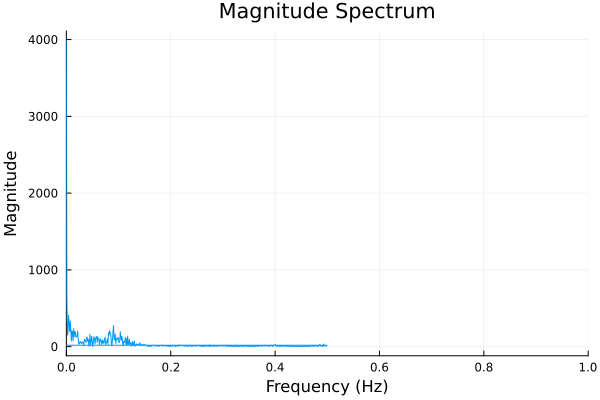

"/mnt/c/Users/Utente/LCP_B/Project/Simulations/Real 1/fourier_spectrum_sim.png"

In [14]:
# VISUALIZATION OF SIMULATED DATA

# Fourier spectrum
plot_fourier_spectrum(data.year, data.open_magn_flux)

In [15]:
# LOADING OF SIMULATION PARAMETERS

load_param_sim()

Row,Parameter,Value
,String15,String
1,prior,"product_distribution(Uniform(1.0, 15.0), Uniform(0.1, 15.0), Uniform(0.1, 6.0), Uniform(0.01, 0.3), Uniform(1.0, 15.0))"
2,n_particles,50
3,n_simulation,1000
4,v,1.0
5,type,1
6,indeces,1:6:115


Data loaded from file: /mnt/c/Users/Utente/LCP_B/Project/Simulations/Real 1/eps_hist.csv
Data loaded from file: /mnt/c/Users/Utente/LCP_B/Project/Simulations/Real 1/u_hist.csv
Data loaded from file: /mnt/c/Users/Utente/LCP_B/Project/Simulations/Real 1/rho_hist.csv
Posterior parameters loaded from file: /mnt/c/Users/Utente/LCP_B/Project/Simulations/Real 1/pop_hist.csv


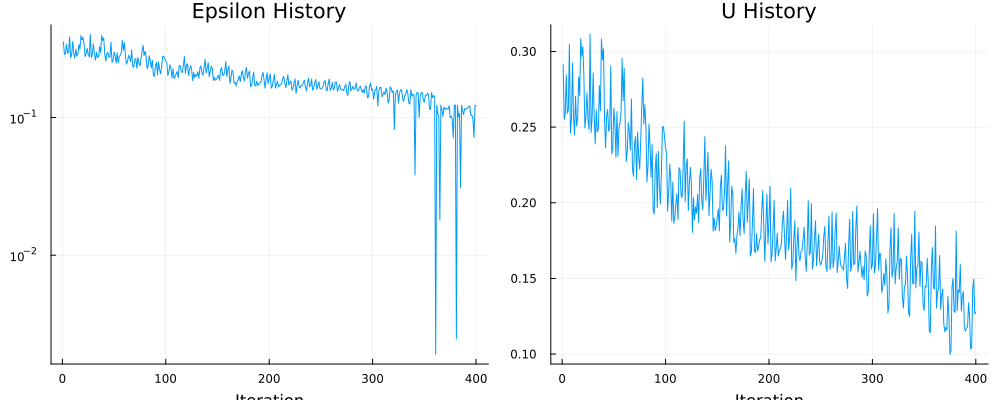

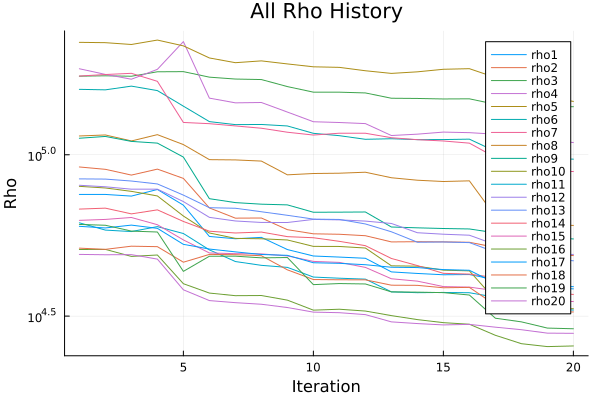

"/mnt/c/Users/Utente/LCP_B/Project/Simulations/Real 1/rho_together.png"

In [16]:
# LOADING AND PLOTTING OF SIMULATION RESULTS AND BEHAVIOUR

# Results loading 
eps_hist, u_hist, rho_hist, posterior_params = load_result()

# Epsilon, u and rho behaviour
u_eps_plot(eps_hist, u_hist)
rho_plot(rho_hist, style = "together")

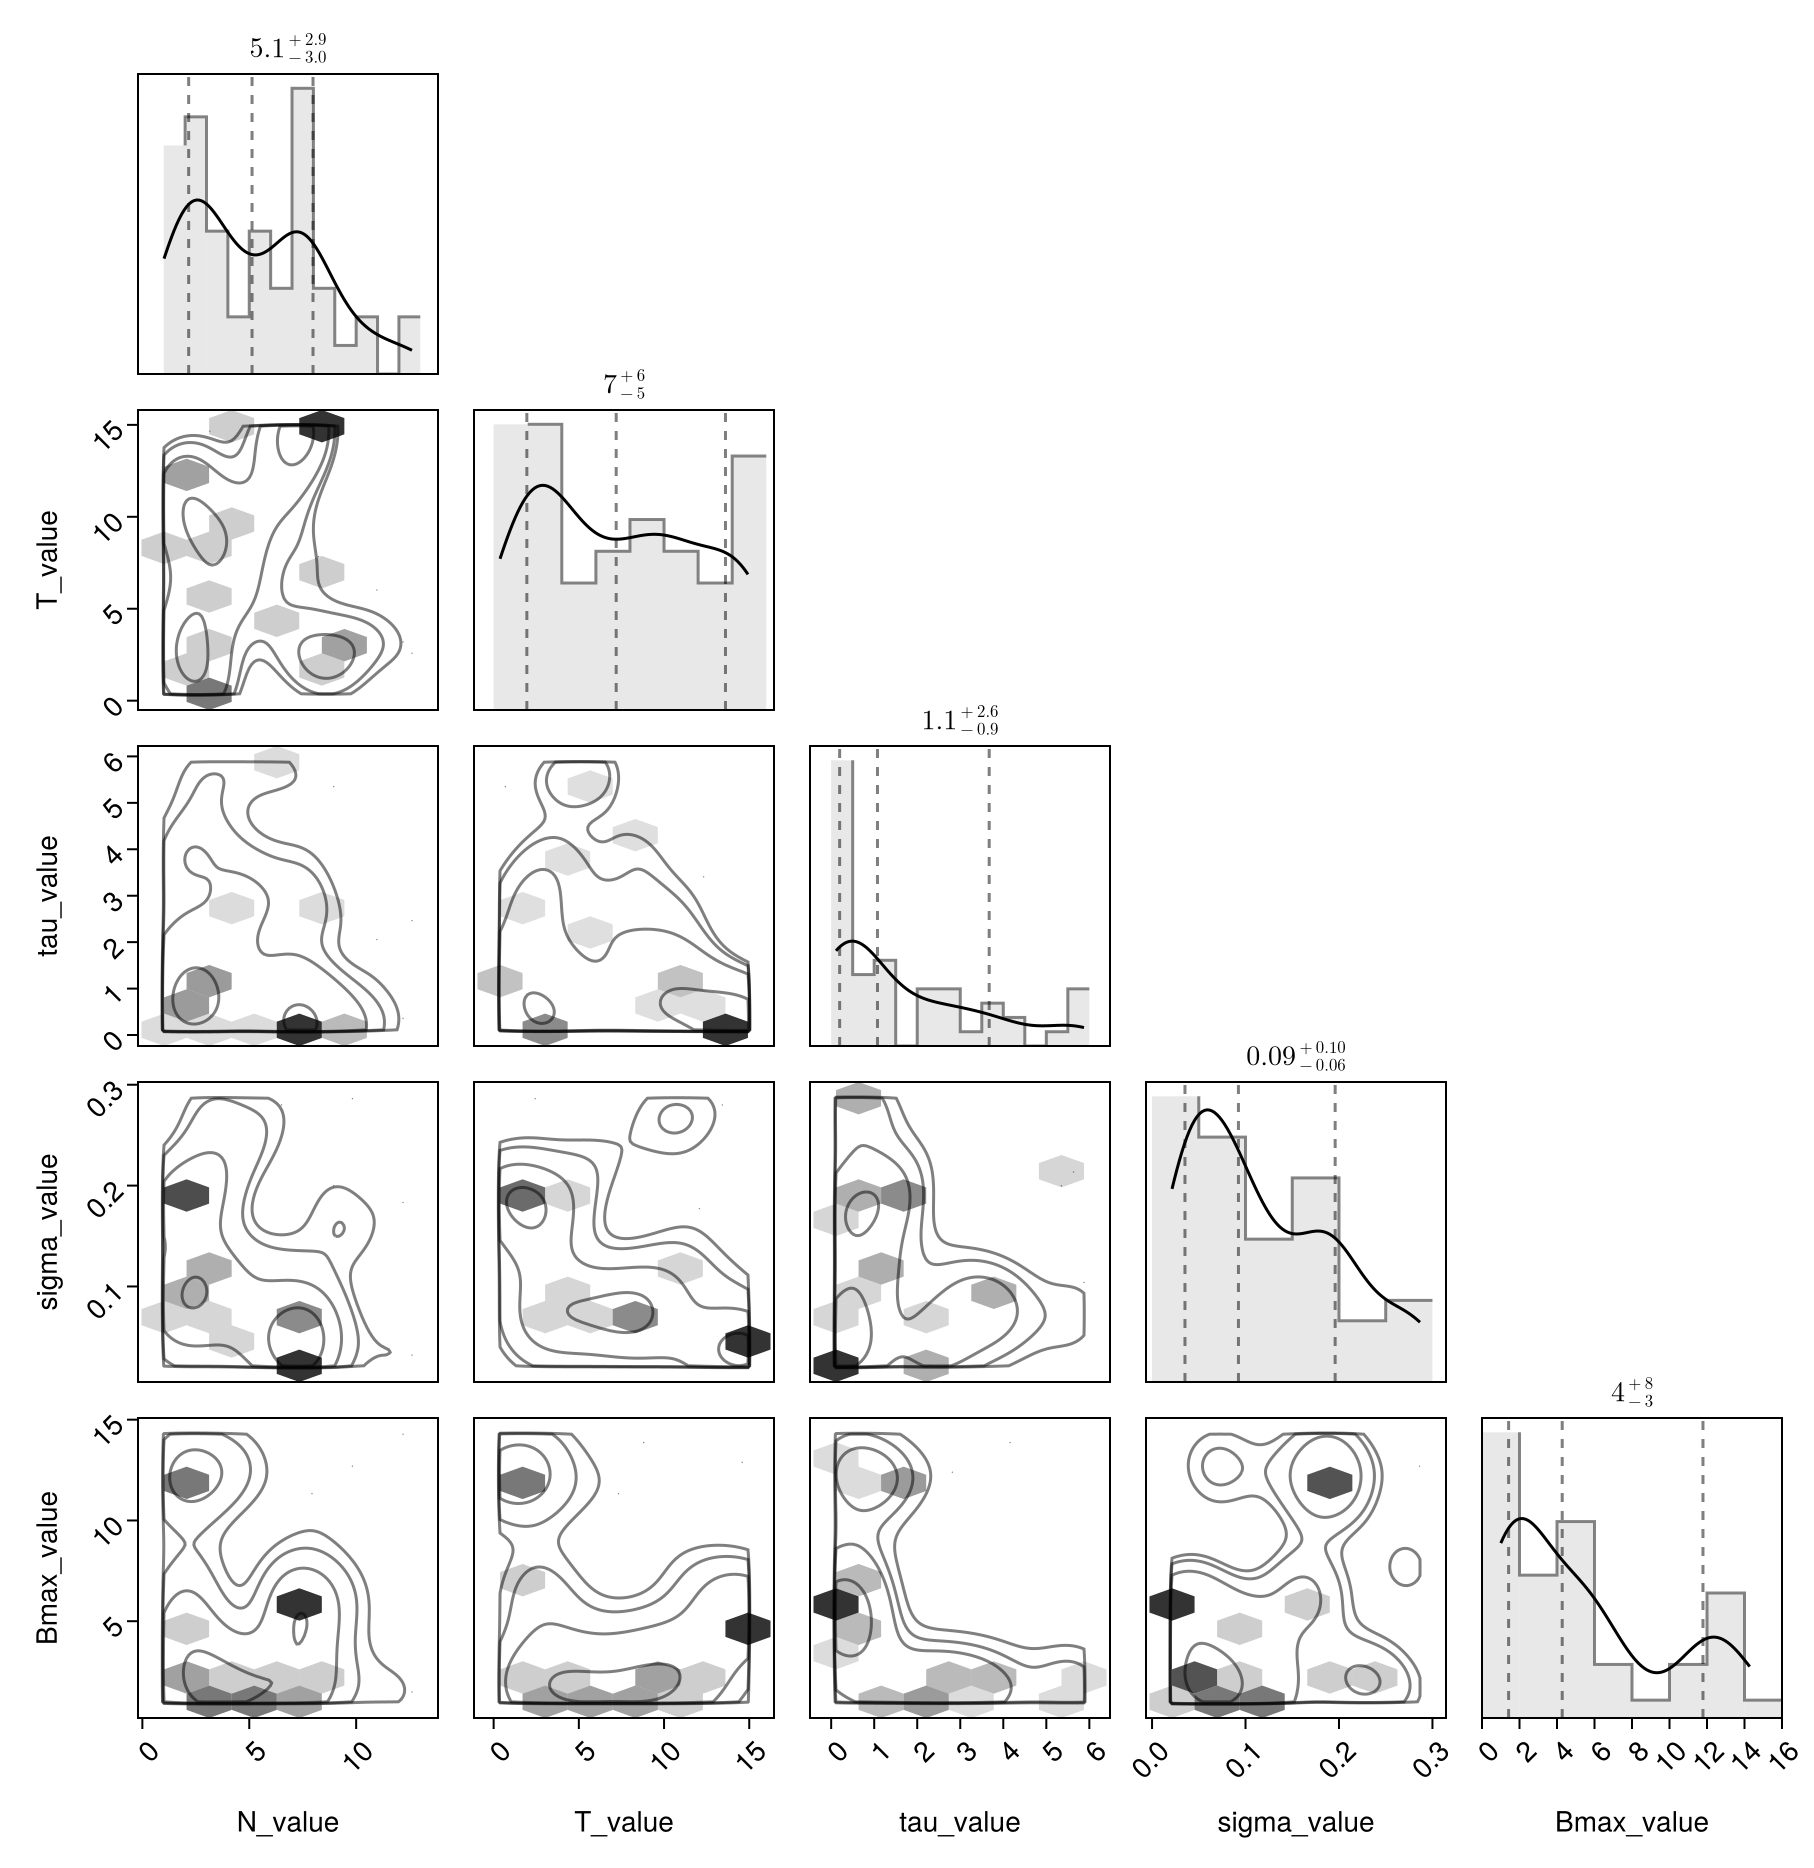

CairoMakie.Screen{IMAGE}


In [21]:
# POSTERIORS PLOTTING

# Corner plot
post_plotting(posterior_params)

In [22]:
# DIRECTORY MANAGING

# WE go back to the initial directory
cd(initial_dir)
pwd()

"/mnt/c/Users/Utente/LCP_B/Project"